# De novo molecule design with chemical language models

Francesca Grisoni*, Gisbert Schneider <div>
    
f.grisoni@tue.nl

## Table of Contents
1. [Preliminary steps](#prel)
2. [Model and fine tuning settings](#sets)
    1. [Architecture](#arch)
    2. [Fine-tuning](#ft) 
    3. [Sampling](#sampl) 
3. [Fine-tuning data](#data)
    1. [Import and analyze](#imp)
    2. [Molecule preparation](#prep) 
4. [License](#License)
5. [How to cite](#cite)

## 1. Preliminary steps <a name="prel"></a>

In the following lines, we add the necessary repo folders to the path. Do not delete these lines if you want the notebook to work. However, you can import additional packages you might need.

In [46]:
# adds the paths to the repo folder
import sys
sys.path.insert(1, '../preprocessing/') # preprocessing code
sys.path.insert(1, '../experiments/') # folder with configuration files
sys.path.insert(1, '../data/') # data code
sys.path.insert(1, '../model/') # model code
sys.path.insert(1, '../evaluation/') # model code
import os
# repo modules
from main_preprocessor import preprocess_data #for data preprocessing
import configparser # to automatically change the .ini file
from sample import Sampler

# other modules
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw # for molecule depiction
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Scaffolds import MurckoScaffold
import ChemTools
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Model and fine-tuning settings <a name="sets"></a>

### Model architecture <a name="arch"></a>
As the first thing, we need to choose the settings for our model. Such settings will be used to prepare the data and for the fine-tuning procedure.
In particular, you need to set each of the following elements:
* *model* (str): type of RNN to use, *i.e.* 'BIMODAL' or 'ForwardRNN'  
* *network_size* (int): total number of hidden units (recommended: 1024)
* *start* (str): position of the starting token for BIMODAL ('fixed' or 'random')
* *augmentation_level* (int): level of augmentation for BIMODAL, recommended 5 (1 is no augmentation).

For this exercise, we choose the settings as specified below.

In [5]:
model = 'BIMODAL'
start = 'random' 
augmentation_level = 5 
network_size = 512

### Fine-tuning settings <a name="ft"></a>
Now, we need to specify how we want the model to be fine-tuned. In what follows, you can specify these options:
* *fine_tuning* (str): name of the dataset for fine-tuning (without file extension). If the set is in /data, only the name is sufficient, otherwise, specify the full path; only .csv and tar.xz are admitted.
* *epochs* (int): number of fine-tuning epochs. The higher the number, the closer the design to the fine-tuning molecules.

In [6]:
# training process
fine_tuning = 'fine_tuning' 
epochs = 25

### Sampling settings <a name="sampl"></a>
Finally, we can specify how we want to sample from the fine-tuned model:
* *T_sampling* (double): temperature for sampling. This represents how "fuzzy" the sampling will be, reflecting in the diversity of the designs (the higher, the higher the diversity). Reccomended 0.7.
* *n_sampling* (int): number of SMILES strings to sample at each fine-tuning epoch
* sample_valid (bool): if set to True, only valid SMILES are considered to reach *n_sampling* 
* sample_novel (bool): if set to True, only SMILES not included in the training set are considered to reach *n_sampling* 
* *sample_unique* (bool): if set to True, only SMILES corrisponding to different molecules are considered to reach *n_sampling* 
For the exercise, we chose the settings below:

In [7]:
# sampling process
T_sampling = 0.7 
n_sampling = 1000

## 3. Fine tuning data  <a name="data"></a>

### Import and analyze fine tuning data  <a name="imp"></a>

#### SMILES strings

The fine-tuning data for this example are provided in the [/example](example) folder, as a .csv file (*fine_tuning.csv*). You can visualize the content of the file with the following lines of code:

In [8]:
ft_set = pd.read_csv('../example/fine_tuning.csv',header=None) 
ft_set.head() # preview

,0
0,CC1=CC2=C(C=C1C(=C)C3=CC=C(C=C3)C(=O)O)C(CCC2(...
1,CC(=CC=CC(C)=CC(=O)O)c1cc(-c2ccc(F)cc2)cc(C(C)...
2,CC(=CC=CC(C)=CC(=O)O)c1cc(C(C)(C)C)cc(C(C)(C)C...
3,CC1=C(C=CC(C)=CC=CC(C)=CC(=O)O)C(C)(C)CCC1


We can also look have a look at each SMILES individually, e.g. with the following command:

In [9]:
smiles = ft_set.iloc[0,0] # molecule in row no. 0 (bexarotene)
smiles

'CC1=CC2=C(C=C1C(=C)C3=CC=C(C=C3)C(=O)O)C(CCC2(C)C)(C)C'

This string can be converted into a depiction with the following command available in RDKit

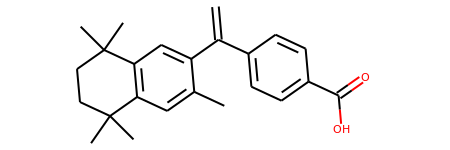

In [10]:
mol = Chem.MolFromSmiles(smiles)
mol # for display

RDKit can be also used to obtain a canonicalized SMILES, as follows:

In [11]:
Chem.MolToSmiles(mol)

'C=C(c1ccc(C(=O)O)cc1)c1cc2c(cc1C)C(C)(C)CCC2(C)C'

The canonical SMILES obtained will always be univocal for the same molecule, while other SMILES strings might be different.

#### Fine-tuning molecules

In this example, we will import molecules as an rdkit supplier, which allows us to visualize them easily

In [62]:
ft_mols = Chem.SmilesMolSupplier('../example/fine_tuning.csv',nameColumn=-1,titleLine=False)
number_mol = len(mols) # number of molecules in your list
number_mol # prints the number of molecules

568

Visualize the chosen fine-tuning molecules

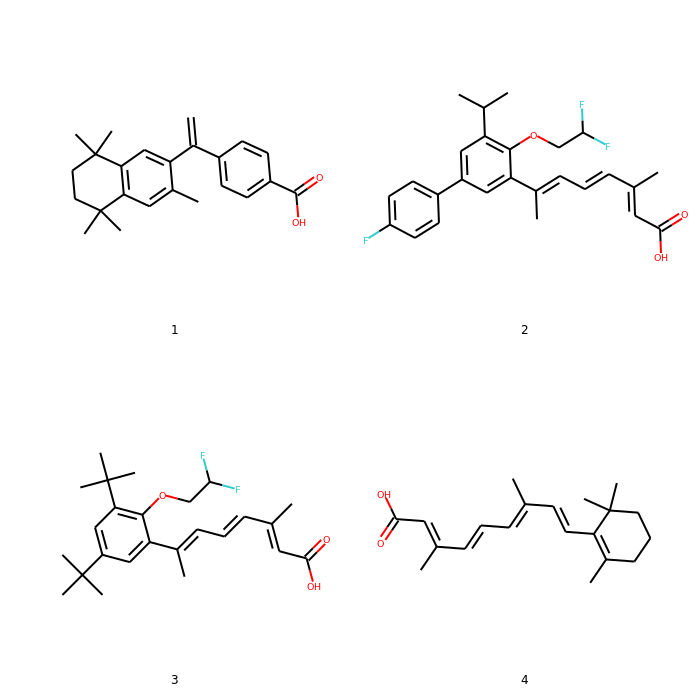

In [63]:
Draw.MolsToGridImage(ft_mols, molsPerRow=2, subImgSize=(350,350),legends=[str(i+1) for i in range(number_mol)])

## 4. Model fine-tuning <a name="prep"></a>

### Prepare the molecules for fine-tuning  <a name="prep"></a>

In this notebook, we will use BIMODAL, with random start, 5x augmentation, and a net size of 1024, as specified above. <div>
Thus, we need to process the fine-tuning data accordingly, before model training.

In [14]:
# Uncomment the following line to execute the pretreatment again. Attention: this will overwrite the existing file!
#preprocess_data(filename_in='fine_tuning', model_type=model, starting_point=start, augmentation=augmentation_level)

You can also inspect your molecules to see the effect of the preparation for fine-tuning your model:


In [15]:
filepath = '../data/'+ fine_tuning + '_' + model + '_' + start + '.csv' #path to the pretreated file based on the settings
ft_set = pd.read_csv(filepath,header=None) 
ft_set.head() # preview

,0,1,2,3,4
0,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEC=C(c1cc...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEC=C(c1ccc(...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
1,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAECC(C=...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAECC(C=CC...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
2,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAECC(C=CC...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,AAAAAAAAAAAAAAAAAAAAAAECC(C=CC=C(C)c1cc(-c2ccc...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAECC(C=CC=C(C)c1...
3,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAECC(C=CC=C(C...


Each row will correspond to one fine-tuning molecule, while each column will be referred to one "augmented" version. The 'A' token is used for padding, i.e., to allow each string to have the same length, independently of the length of the original SMILES string. 

You can print all the strings (without the 'A' token) referring, for instance, to bexarotene (row 0):

In [84]:
for i in range(0,augmentation_level):
    print(ft_set.iloc[0,i].replace('A',''))

ECG=C(c1ccc(C(=O)O)cc1)c1cc2c(cc1C)C(C)(C)CCC2(C)CE
EC=C(c1ccc(C(=O)O)cc1)c1cGc2c(cc1C)C(C)(C)CCC2(C)CE
EC=C(c1ccc(C(=O)O)cc1)c1cc2c(cc1C)C(C)G(C)CCC2(C)CE
EC=C(c1ccc(C(=O)O)cc1)c1cc2c(cc1C)C(C)(CG)CCC2(C)CE
EC=C(c1ccc(C(=O)O)cc1)c1ccG2c(cc1C)C(C)(C)CCC2(C)CE


Note that every time the pretreatment procedure is repeated, different positioning of the G token will be obtained, due to the random placement.

### Fine-tune your model  <a name="prep"></a>

To be trained, the model needs to rely on a configuration file. <div>
To help you with this, we prepared a function, called *make_config*, to do so easily. <div>
The file will be saved as (["Example_FineTuning.ini"](../experiments/)). You can also edit the file manually to change some desired options.

In [16]:
import utils
exp_name = utils.make_config(model_type=model, net_size=network_size, epochs=epochs, starting_point=start, fine_tuning='fine_tuning', n_sampling=n_sampling,T_sampling=T_sampling,augmentation_level=augmentation_level)

Now, you are ready to fine tune the model!

In [88]:
import fine_tuner
t = fine_tuner.FineTuner(experiment_name = exp_name)
#Uncomment the following line to start the fine-tuning. Attention, results will be overwritten!
#t.fine_tuning(stor_dir='../evaluation/')

/home/francesca/anaconda3/envs/de_novo/lib/python3.7/site-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'bidir_lstm.BiDirLSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25


## 5. Analysis of the results

### Cross-entropy loss at each epoch

We can check how the model learnt across the epochs, by evaluating the variation of the cross-entropy loss:

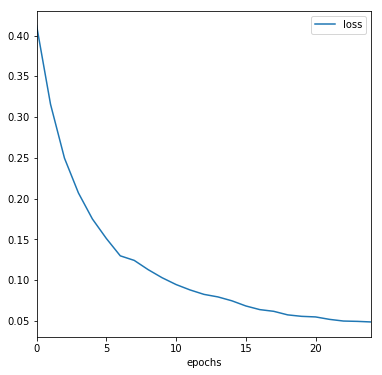

In [17]:
loss = pd.read_csv('../evaluation/'+ exp_name + '/statistic/stat_fold_1.csv',header=None)
loss.columns = ["epochs", "loss"]
loss.plot.line(x=0, y=1,figsize=(6,6))

### Analysis of the designs

The sampled files will be stored in a dedicated folder, under /evaluation/"exp_name"/molecules/. The SMILES generated at a given epoch (e.g., 5) can be imported as follows:

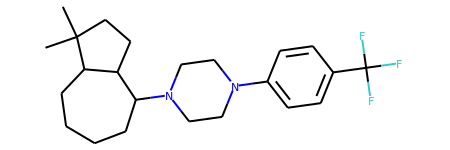

In [18]:
epoch = 5
file_path = '../evaluation/' + exp_name + '/molecules/' + 'molecule_fold_1_epochs_' + str(epoch-1) + '.csv' # generates the filename
mols = Chem.SmilesMolSupplier(file_path,smilesColumn=1,nameColumn=-1,titleLine=False,delimiter=',')
# displays one molecule (e.g., first one)
mols[0]

You can compute the unique scaffolds

### Validity, uniquennes and novelty analysis

To analyse how many valid, unique and novel molecules were produced per epoch, you can find a utility within the ChemTools. The utlity can be used as follows: 

``` novelty_vs_epochs(folder,ft_path,export)``` 

where
* *folder* (str) is the path to the folder containing the smiles lists (as csv)
* *ft_path* (str) is the path to the fine tuning set original file
* *export* (bool) determines whether a file with the valid, unique, and novel smiles is saved for each epoch (in the results folder, under, "molecules_novel").

For advanced options, check the code file. Below, you will find an example on how to use the code.

In [19]:
from ChemTools import novelty_vs_epochs
folder = '../evaluation/' + exp_name + '/' # generates the folder path automatically
stats = novelty_vs_epochs(folder,ft_path='../example/fine_tuning.csv',export=True)

Analysing file: molecule_fold_1_epochs_0.csv
Analysing file: molecule_fold_1_epochs_1.csv
Analysing file: molecule_fold_1_epochs_2.csv
Analysing file: molecule_fold_1_epochs_3.csv
Analysing file: molecule_fold_1_epochs_4.csv
Analysing file: molecule_fold_1_epochs_5.csv
Analysing file: molecule_fold_1_epochs_6.csv
Analysing file: molecule_fold_1_epochs_7.csv
Analysing file: molecule_fold_1_epochs_8.csv
Analysing file: molecule_fold_1_epochs_9.csv
Analysing file: molecule_fold_1_epochs_10.csv
Analysing file: molecule_fold_1_epochs_11.csv
Analysing file: molecule_fold_1_epochs_12.csv
Analysing file: molecule_fold_1_epochs_13.csv
Analysing file: molecule_fold_1_epochs_14.csv
Analysing file: molecule_fold_1_epochs_15.csv
Analysing file: molecule_fold_1_epochs_16.csv
Analysing file: molecule_fold_1_epochs_17.csv
Analysing file: molecule_fold_1_epochs_18.csv
Analysing file: molecule_fold_1_epochs_19.csv
Analysing file: molecule_fold_1_epochs_20.csv
Analysing file: molecule_fold_1_epochs_21.cs

Because of the option "export=True", a new folder will be created, containing only novel, unique and valid molecules. This will be found in your results folder (e.g., /evaluation/BIMODAL_random_512_aug_5_FineTuning/) and will be called "molecules_novel".

Now you can analyse the statistics for each fine-tuning epoch, as saved in the "stats" dataframe. This dataframe contains one epoch per row and the corresponding number of valid, unique and novel molecules:

In [20]:
stats.head() # preview

,valid,unique,novel
0,911.0,909.0,901.0
1,916.0,913.0,911.0
2,908.0,908.0,906.0
3,892.0,891.0,890.0
4,882.0,878.0,874.0


This file can be exported as a csv ("novelty_results"), e.g., by creating a folder named "analysis" in your experiment folder

In [22]:
results_path = '../evaluation/' + exp_name + '/analysis'
if os.path.exists(results_path) is False: # checks if the folder exists, and otherwise creates it
    os.mkdir(results_path)

stats.to_csv(results_path + '/novelty_results.csv')

You can also inspect the results visually with a barplot

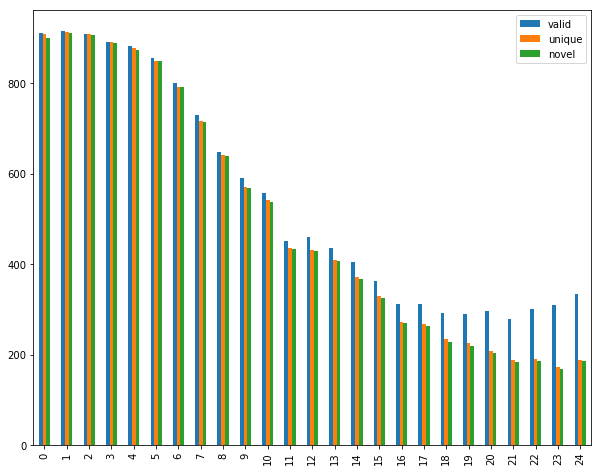

In [226]:
stats.plot.bar(figsize=(10,8))

### Scaffold analysis

To analyse how many unique scaffolds are produced per epoch, you can find a utility within the ChemTools. The utlity can be used as follows: 

```scaffolds_vs_epochs(folder)``` 

where
* *folder* (str) is the path to the folder containing the smiles lists (as csv).

In this example, we will only load the valid, unique and novel molecules for our analysis, as follows:

In [233]:
from ChemTools import scaffolds_vs_epochs
folder = '../evaluation/' + exp_name + '/molecules_novel/'
scaffold_res = scaffolds_vs_epochs(folder)

"scaffold_res" is a dataframe, containing the number of unique scaffolds per epoch, as well as the percentage over the total number of analyzed SMILES.

In [234]:
scaffold_res.head()

,No_unique,Perc_unique
0,828,0.918979
1,821,0.901207
2,802,0.885210
3,764,0.858427
4,720,0.823799


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbd197f5250>,
      dtype=object)

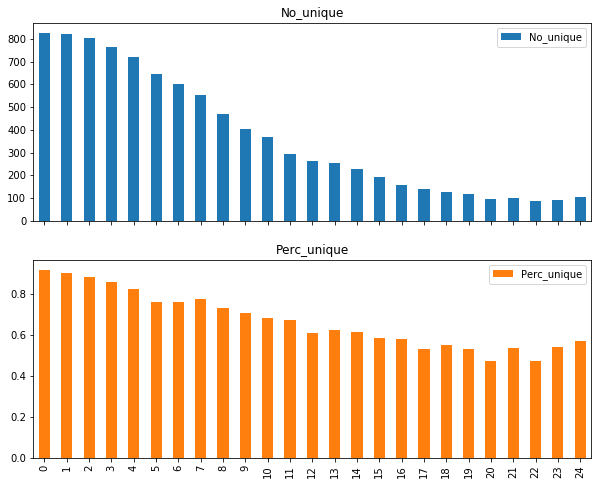

In [239]:
# saves the results
scaffold_res.to_csv(results_path + '/scaffolds_results.csv')
# displays
scaffold_res.plot.bar(figsize=(10,8),subplots=True)

### Morgan similarity

To analyse how many unique scaffolds are produced per epoch, you can find a utility within the ChemTools. The utlity can be used as follows:

```scaffolds_vs_epochs(folder,path_ft)```

where

* *folder* (str) is the path to the folder containing the smiles lists (as csv).
* *path_ft* (str) is the path to the fine-tuning data file.

In this example, we will only load the valid, unique and novel molecules for our analysis, as follows:

In [31]:
from ChemTools import morgan_vs_epochs
folder = '../evaluation/' + exp_name + '/molecules_novel/'
sim_res = ChemTools.morgan_vs_epochs(folder,path_ft='../example/fine_tuning.csv')

The obtained file contains the minimum, mean and max similarity to the fine-tuning set at each epoch:

In [30]:
sim_res.head()

,MinSim,MeanSim,MaxSim
0,0.013986,0.121542,0.494505
1,0.012422,0.125684,0.298246
2,0.013158,0.128379,0.416667
3,0.012658,0.133449,0.423729
4,0.014388,0.137681,0.538462


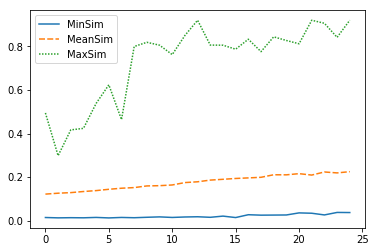

In [41]:
# saves the results
sim_res.to_csv(results_path + '/similarity_results.csv')
# displays
import seaborn as sns
sns.lineplot(data=sim_res, ci=1000)

### Selected epoch

Based on the results of the analysis, you can now select one or more epochs to use for your project. For instance, you could choose epoch 10 and analyse the most frequent atomic scaffolds in there, as follows:

In [79]:
epoch = 25
file_path = '../evaluation/' + exp_name + '/molecules_novel/' + 'molecule_fold_1_epochs_' + str(epoch-1) + '.csv' # generates the filename
designs = Chem.SmilesMolSupplier(file_path,smilesColumn=0,titleLine=False,delimiter=',')

In [80]:
from ChemTools import frequent_scaffolds
freq_scaffolds = frequent_scaffolds(designs)

Draw the scaffolds of the de novo designs

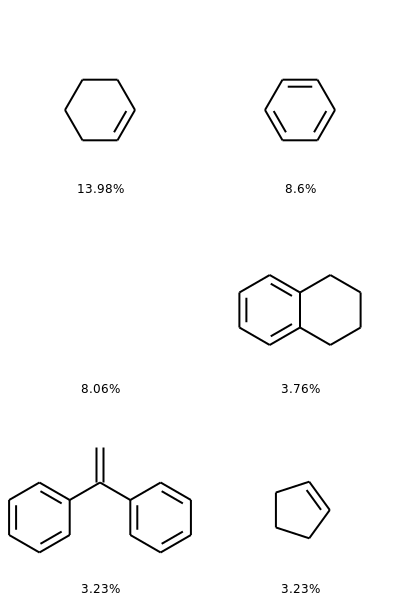

In [81]:
k = 6 # number of scaffolds to depict
Draw.MolsToGridImage(freq_scaffolds[:k],molsPerRow=2,subImgSize=(200,200),legends=[x.GetProp("_Name") for x in freq_scaffolds[:k]])

You can compare them with the fine-tuning scaffolds

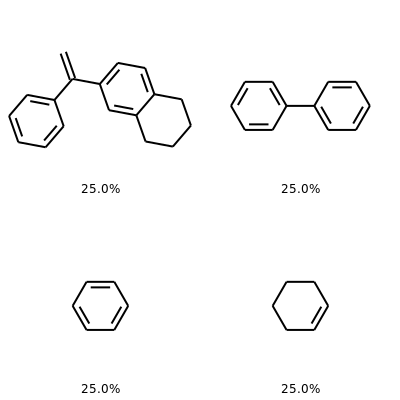

In [66]:
ft_scaffolds = frequent_scaffolds(ft_mols)
Draw.MolsToGridImage(ft_scaffolds,molsPerRow=2,subImgSize=(200,200),legends=[x.GetProp("_Name") for x in ft_scaffolds])


In [75]:
Chem.MolToSmiles(freq_scaffolds[3])

'O=C(Nc1ccccc1)c1ccccc1'